In [1]:
## importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import glob
import shutil

from tensorflow.keras.layers import Dense , Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.model_selection import train_test_split

import cv2
import time

from tqdm import tqdm

In [11]:
## upload the kaggle json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [12]:
!kaggle datasets download -d phucthaiv02/butterfly-image-classification

 90% 204M/226M [00:01<00:00, 175MB/s]
100% 226M/226M [00:01<00:00, 179MB/s]


In [13]:
from zipfile import ZipFile

dataset = "/content/butterfly-image-classification.zip"

with ZipFile(dataset,"r" ) as zip:
  zip.extractall()
  print("the dataset has been extracted ".title())

The Dataset Has Been Extracted 


In [14]:
## lets have train and test data path

train_dir = "/content/train"
test_dir = "/content/test"

In [15]:
## lets see what is present in csv

train_df = pd.read_csv("/content/Training_set.csv")
test_df = pd.read_csv("/content/Testing_set.csv")

In [16]:
train_df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


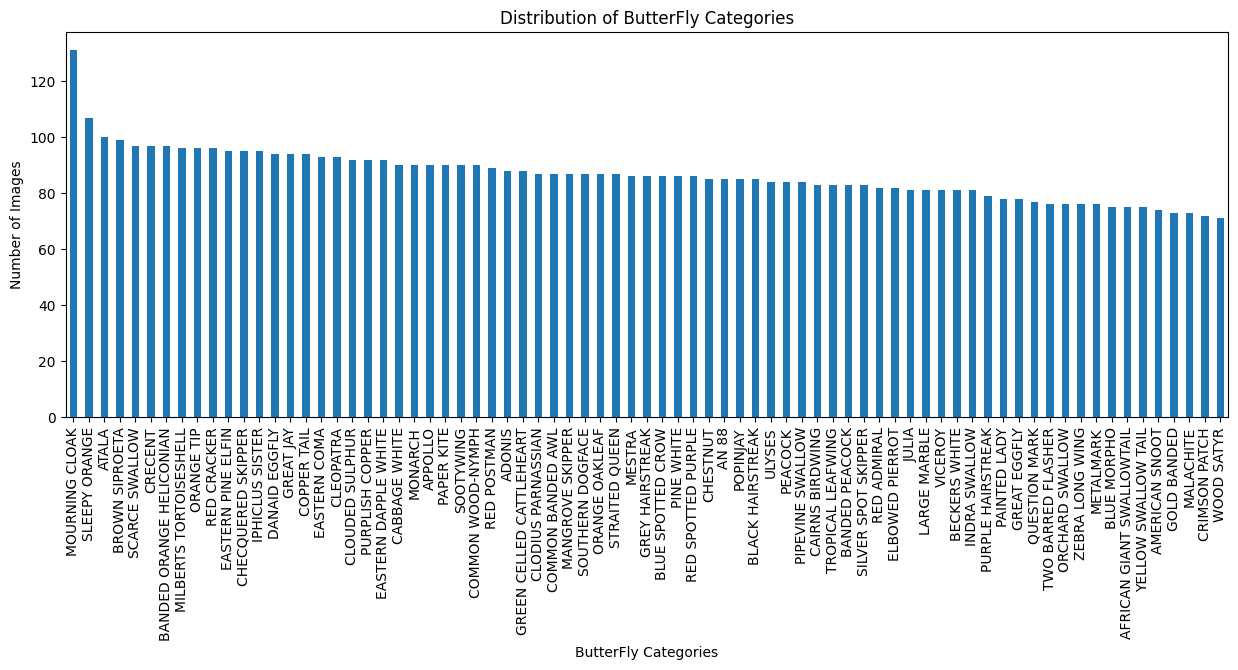

In [17]:
## lets see the distribution of butterfly classes across the dataset


plt.figure(figsize = (15,5))
train_df["label"].value_counts().plot(kind = "bar")
plt.title("Distribution of ButterFly Categories")
plt.xlabel("ButterFly Categories")
plt.ylabel("Number of Images")
plt.show()

In [21]:
class_names = list(set(train_df["label"]))

In [23]:
# image_size = (150,150)
image_size = (224,224)

In [24]:
## lets initilize feature and labels for dataset

features  = []
labels = []


for image in tqdm(os.listdir(train_dir),desc = "Preprocessing of Images"):
  label_name = train_df.loc[train_df["filename"]==image,"label"].values[0]
  label = class_names.index(label_name)
  image_read = cv2.imread(os.path.join(train_dir,image))
  image_resize = cv2.resize(image_read,image_size )
  image_normalized = image_resize/255
  features.append(image_normalized)
  labels.append(label)


Preprocessing of Images: 100%|██████████| 6499/6499 [00:15<00:00, 411.23it/s]


In [25]:
### convert the data in array

features = np.asarray(features)
labels = np.asarray(labels)

In [26]:
## split the data set

x_train, x_test, y_train, y_test = train_test_split(
                                            features,
                                            labels,
                                            train_size = 0.7,
                                            random_state = 42
)

In [27]:
x_valid, x_test, y_valid, y_test = train_test_split(
                                            x_test,
                                            y_test,
                                            test_size = 0.7,
                                            random_state = 42
)

In [28]:
x_train.shape,x_test.shape,x_valid.shape

((4549, 224, 224, 3), (1365, 224, 224, 3), (585, 224, 224, 3))

In [29]:
## lets have some libraries

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [30]:
## this are nothing but the links of the model
## basicall reference to the model

resnet_v2_50 = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/2"

resnet_v2_101 = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/101-feature-vector/2"

resnet_v2_152 = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/152-feature-vector/2"

In [31]:
### create an instanec of the model '

def create_model(model_url , num_classes = 75):
  global feature_extractor_layer
  feature_extractor_layer = hub.KerasLayer(
                                          model_url,
                                          trainable = False,
                                          input_shape = image_size + (3,)
  )

  model = tf.keras.Sequential([
                          feature_extractor_layer,
                          Dense(256,activation = "relu"),
                          Dense(num_classes,activation = "softmax",name = "Output_Layer")
  ])

  return model

In [32]:
model = create_model(resnet_v2_50,num_classes = 75)

In [33]:
## compile the model

model.compile(
    optimizer= Adam(),
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    metrics = ["accuracy"]
)

In [34]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint


checkpoint = ModelCheckpoint(
                      filepath = "Resnet_v2_50_pb.h5",
                      verbose = True,
                      save_best_only = True
)

callbacks = [checkpoint]

start = datetime.now()

history = model.fit(
                  x_train ,
                  y_train,
                  validation_data = (x_valid,y_valid),
                  epochs = 5,
                  batch_size = 64,
                  callbacks = callbacks,
                  verbose = True
)

duration = datetime.now() - start


print("training is completed".title())

Epoch 1/5
72/72 [==============================] - ETA: 0s - loss: 2.0105 - accuracy: 0.5221
Epoch 1: val_loss improved from inf to 0.91899, saving model to Resnet_v2_50_pb.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 70s 920ms/step - loss: 2.0105 - accuracy: 0.5221 - val_loss: 0.9190 - val_accuracy: 0.7504
Epoch 2/5
72/72 [==============================] - ETA: 0s - loss: 0.5580 - accuracy: 0.8622
Epoch 2: val_loss improved from 0.91899 to 0.65869, saving model to Resnet_v2_50_pb.h5
72/72 [==============================] - 66s 919ms/step - loss: 0.5580 - accuracy: 0.8622 - val_loss: 0.6587 - val_accuracy: 0.8000
Epoch 3/5
72/72 [==============================] - ETA: 0s - loss: 0.3062 - accuracy: 0.9242
Epoch 3: val_loss improved from 0.65869 to 0.62778, saving model to Resnet_v2_50_pb.h5
72/72 [==============================] - 66s 923ms/step - loss: 0.3062 - accuracy: 0.9242 - val_loss: 0.6278 - val_accuracy: 0.8222
Epoch 4/5
72/72 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.9589
Epoch 4: val_loss improved from 0.62778 to 0.56809, saving model to Resnet_v2_50_pb.h5
72/72 [==============================] - 68s 945ms/step - loss: 

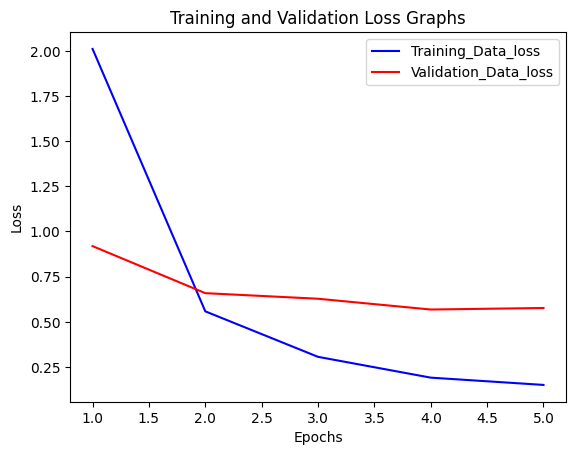

In [35]:
## lets plot loss and accuracy graphs

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,6)
plt.plot(epochs,loss,"b",label = "Training_Data_loss")
plt.plot(epochs,val_loss,"r",label = "Validation_Data_loss")
plt.title("Training and Validation Loss Graphs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

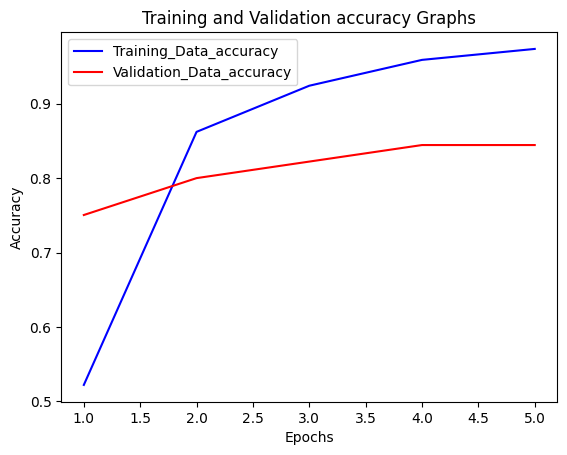

In [36]:
## lets plot loss and accuracy graphs

loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1,6)
plt.plot(epochs,loss,"b",label = "Training_Data_accuracy")
plt.plot(epochs,val_loss,"r",label = "Validation_Data_accuracy")
plt.title("Training and Validation accuracy Graphs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 3.6345 - accuracy: 0.1978
Epoch 1: val_loss improved from inf to 1.99019, saving model to Resnet_v2_50_pb.h5
72/72 [==============================] - 86s 1s/step - loss: 3.6345 - accuracy: 0.1978 - val_loss: 1.9902 - val_accuracy: 0.5983
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 1.9796 - accuracy: 0.4836
Epoch 2: val_loss improved from 1.99019 to 1.25945, saving model to Resnet_v2_50_pb.h5
72/72 [==============================] - 80s 1s/step - loss: 1.9796 - accuracy: 0.4836 - val_loss: 1.2594 - val_accuracy: 0.7316
Epoch 3/10
72/72 [==============================] - ETA: 0s - loss: 1.5173 - accuracy: 0.5909
Epoch 3: val_loss improved from 1.25945 to 0.95157, saving model to Resnet_v2_50_pb.h5
72/72 [==============================] - 80s 1s/step - loss: 1.5173 - accuracy: 0.5909 - val_loss: 0.9516 - val_accuracy: 0.7726
Epoch 4/10
72/72 [==============================] - ETA: 0s - loss: 1.2622

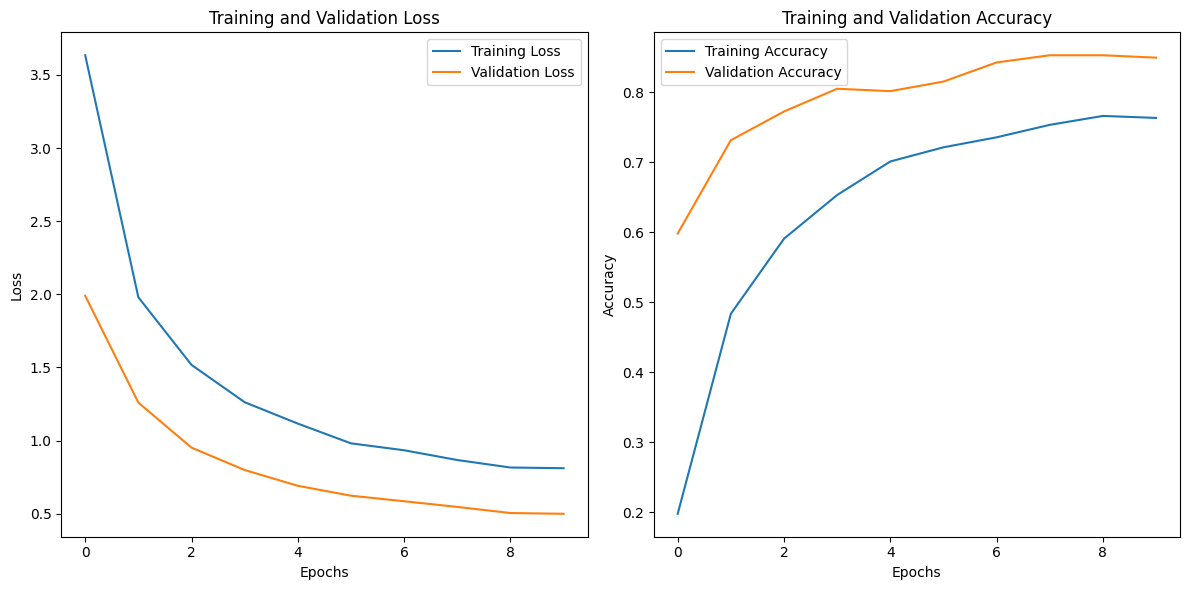

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, BatchNormalization

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow(x_train, y_train, batch_size=64)

# Model with Dropout and BatchNormalization
def create_model(model_url, num_classes=75):
    global feature_extractor_layer
    feature_extractor_layer = hub.KerasLayer(
        model_url,
        trainable=False,
        input_shape=image_size + (3,)
    )

    model = tf.keras.Sequential([
        feature_extractor_layer,
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax", name="Output_Layer")
    ])

    return model

model = create_model(resnet_v2_50, num_classes=75)

# Compile the model
model.compile(
    optimizer=Adam(),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=["accuracy"]
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath="Resnet_v2_50_pb.h5",
    verbose=1,
    save_best_only=True
)

callbacks = [early_stopping, checkpoint]

# Train the model with augmented data
start = datetime.now()

history = model.fit(
    train_generator,
    validation_data=(x_valid, y_valid),
    epochs=10,  # Increase epochs for early stopping
    callbacks=callbacks,
    verbose=1
)

duration = datetime.now() - start

print("Training completed")

# Plot loss and accuracy graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
